In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score

# Data

In [2]:
df = pd.read_csv(r"D:\_Dev\_Group Project\Affinity-Propagation-ML-UEH\Data\Mall Customers\Mall_Customers_preprocessed.csv")

In [3]:
df.head()

,customerid,age,annual_income,spending_score,genre_female
0,1,-1.424569,-1.738999,-0.434801,0.0
1,2,-1.281035,-1.738999,1.195704,0.0
2,3,-1.352802,-1.700830,-1.715913,1.0
3,4,-1.137502,-1.700830,1.040418,1.0
4,5,-0.563369,-1.662660,-0.395980,1.0


In [4]:
X = df.copy()

# Model

In [5]:
# Áp dụng thuật toán DBSCAN
dbscan = DBSCAN(eps=1.4, min_samples=3)
labels = dbscan.fit_predict(X)

In [6]:
core_samples_mask = labels != -1
X_valid = X[core_samples_mask]
labels_valid = labels[core_samples_mask]

n_clusters = len(set(labels_valid))
print(f"Số cụm: {n_clusters}")

if n_clusters > 1:
    db_index = davies_bouldin_score(X_valid, labels_valid)
    ch_index = calinski_harabasz_score(X_valid, labels_valid)
    silhouette = silhouette_score(X_valid, labels_valid)

    print(f"Davies-Bouldin Index: {db_index:.3f}")
    print(f"Calinski-Harabasz Index: {ch_index:.3f}")
    print(f"Silhouette Score: {silhouette:.3f}")
else:
    print("Không đủ cụm hợp lệ để đánh giá")

Số cụm: 4
Davies-Bouldin Index: 0.115
Calinski-Harabasz Index: 2802.343
Silhouette Score: 0.892


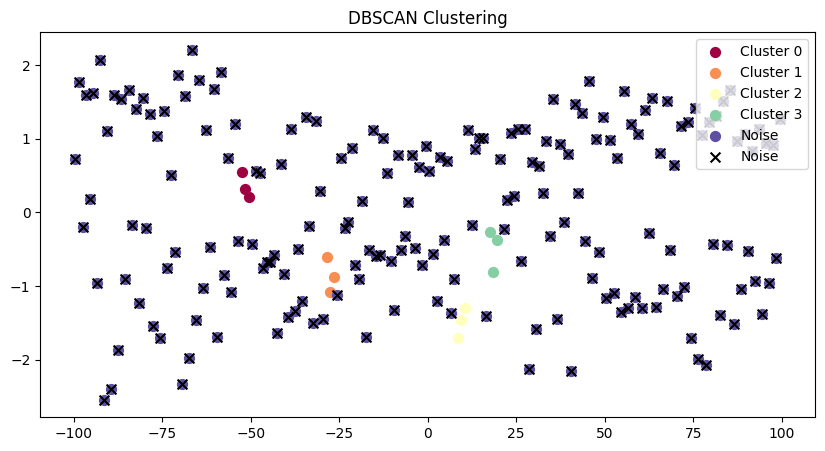

In [7]:
# Giảm chiều xuống 2D với PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Vẽ biểu đồ phân cụm
plt.figure(figsize=(10, 5))

# Sử dụng các màu sắc khác nhau cho các cụm
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    xy = X_pca[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], s=50, c=[col], label=f'Cluster {k}' if k != -1 else 'Noise')

# Đánh dấu các điểm nhiễu (Noise)
plt.scatter(X_pca[labels == -1, 0], X_pca[labels == -1, 1], s=50, c='black', label='Noise', marker='x')
plt.title('DBSCAN Clustering')
plt.legend(loc='upper right')
plt.show()

# Hyperparamter Optimization

In [8]:
best_score = -1
best_params = {}
top_results = []

for eps in np.arange(0.1, 2.0, 0.1):  # thử eps từ 0.1 đến 2
    for min_samples in range(3, 10):  # thử min_samples từ 3 đến 9
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)
        
        # Loại bỏ noise
        if len(set(labels)) > 1 and -1 in labels:
            valid_mask = labels != -1
            try:
                score = silhouette_score(X[valid_mask], labels[valid_mask])
                if score > best_score:
                    best_score = score
                    best_params = {'eps': eps, 'min_samples': min_samples}
                    top_results.append((eps, min_samples, score))
            except:
                pass

In [9]:
best_score = -1
best_params = {}
top_results = []

for eps in np.arange(0.1, 2.0, 0.1):
    for min_samples in range(3, 10):
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(X)

        # Loại bỏ noise
        if len(set(labels)) > 1 and -1 in labels:
            valid_mask = labels != -1
            try:
                X_valid = X[valid_mask]
                labels_valid = labels[valid_mask]

                sil_score = silhouette_score(X_valid, labels_valid)
                dbi = davies_bouldin_score(X_valid, labels_valid)
                chi = calinski_harabasz_score(X_valid, labels_valid)
                n_clusters = len(set(labels_valid))

                result = {
                    "sil_score": sil_score,
                    "dbi": dbi,
                    "chi": chi,
                    "n_clusters": n_clusters,
                    "params": {
                        "eps": eps,
                        "min_samples": min_samples,
                    },
                }

                top_results.append(result)

                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {"eps": eps, "min_samples": min_samples}
            except:
                pass

In [10]:
top_results = sorted(top_results, key=lambda x: x["sil_score"], reverse=True)[:5]
show_results = pd.DataFrame(
    columns=["Top", "Silhouette", "Davies-Bouldin", "Calinski-Harabaz", "Số cụm", 'eps', "min_samples"]
)
for i, res in enumerate(top_results):
    show_results.loc[len(show_results)] = [
        i + 1,
        round(res["sil_score"], 3),
        round(res["dbi"], 3),
        round(res["chi"], 3),
        res["n_clusters"],
        res["params"]["eps"],
        res["params"]["min_samples"],
    ]
show_results

,Top,Silhouette,Davies-Bouldin,Calinski-Harabaz,Số cụm,eps,min_samples
0,1.0,0.978,0.023,5390.593,2.0,1.1,3.0
1,2.0,0.892,0.115,2802.343,4.0,1.4,3.0
2,3.0,0.889,0.117,4089.259,3.0,1.2,3.0
3,4.0,0.889,0.117,4089.259,3.0,1.3,3.0
4,5.0,0.759,0.269,1963.442,6.0,1.5,3.0
